<a href="https://colab.research.google.com/github/hichemfelouat/my-codes-of-machine-learning/blob/master/Transformer_for_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Transformer model in Attention is all you need： A Keras implementation for machine translation**

**Author:** [Hichem Felouat](https://www.linkedin.com/in/hichemfelouat/)<br>

**Description:** In this notebook, we will build a Transformer model like the [Attention is all you need](https://arxiv.org/abs/1706.03762) model, which we will train on an English-to-French machine translation task.

[**Language Translation (English-French) Dataset**](https://www.kaggle.com/devicharith/language-translation-englishfrench)

[**Illustrated Guide to Transformers- Step by Step Explanation**](https://towardsdatascience.com/illustrated-guide-to-transformers-step-by-step-explanation-f74876522bc0)

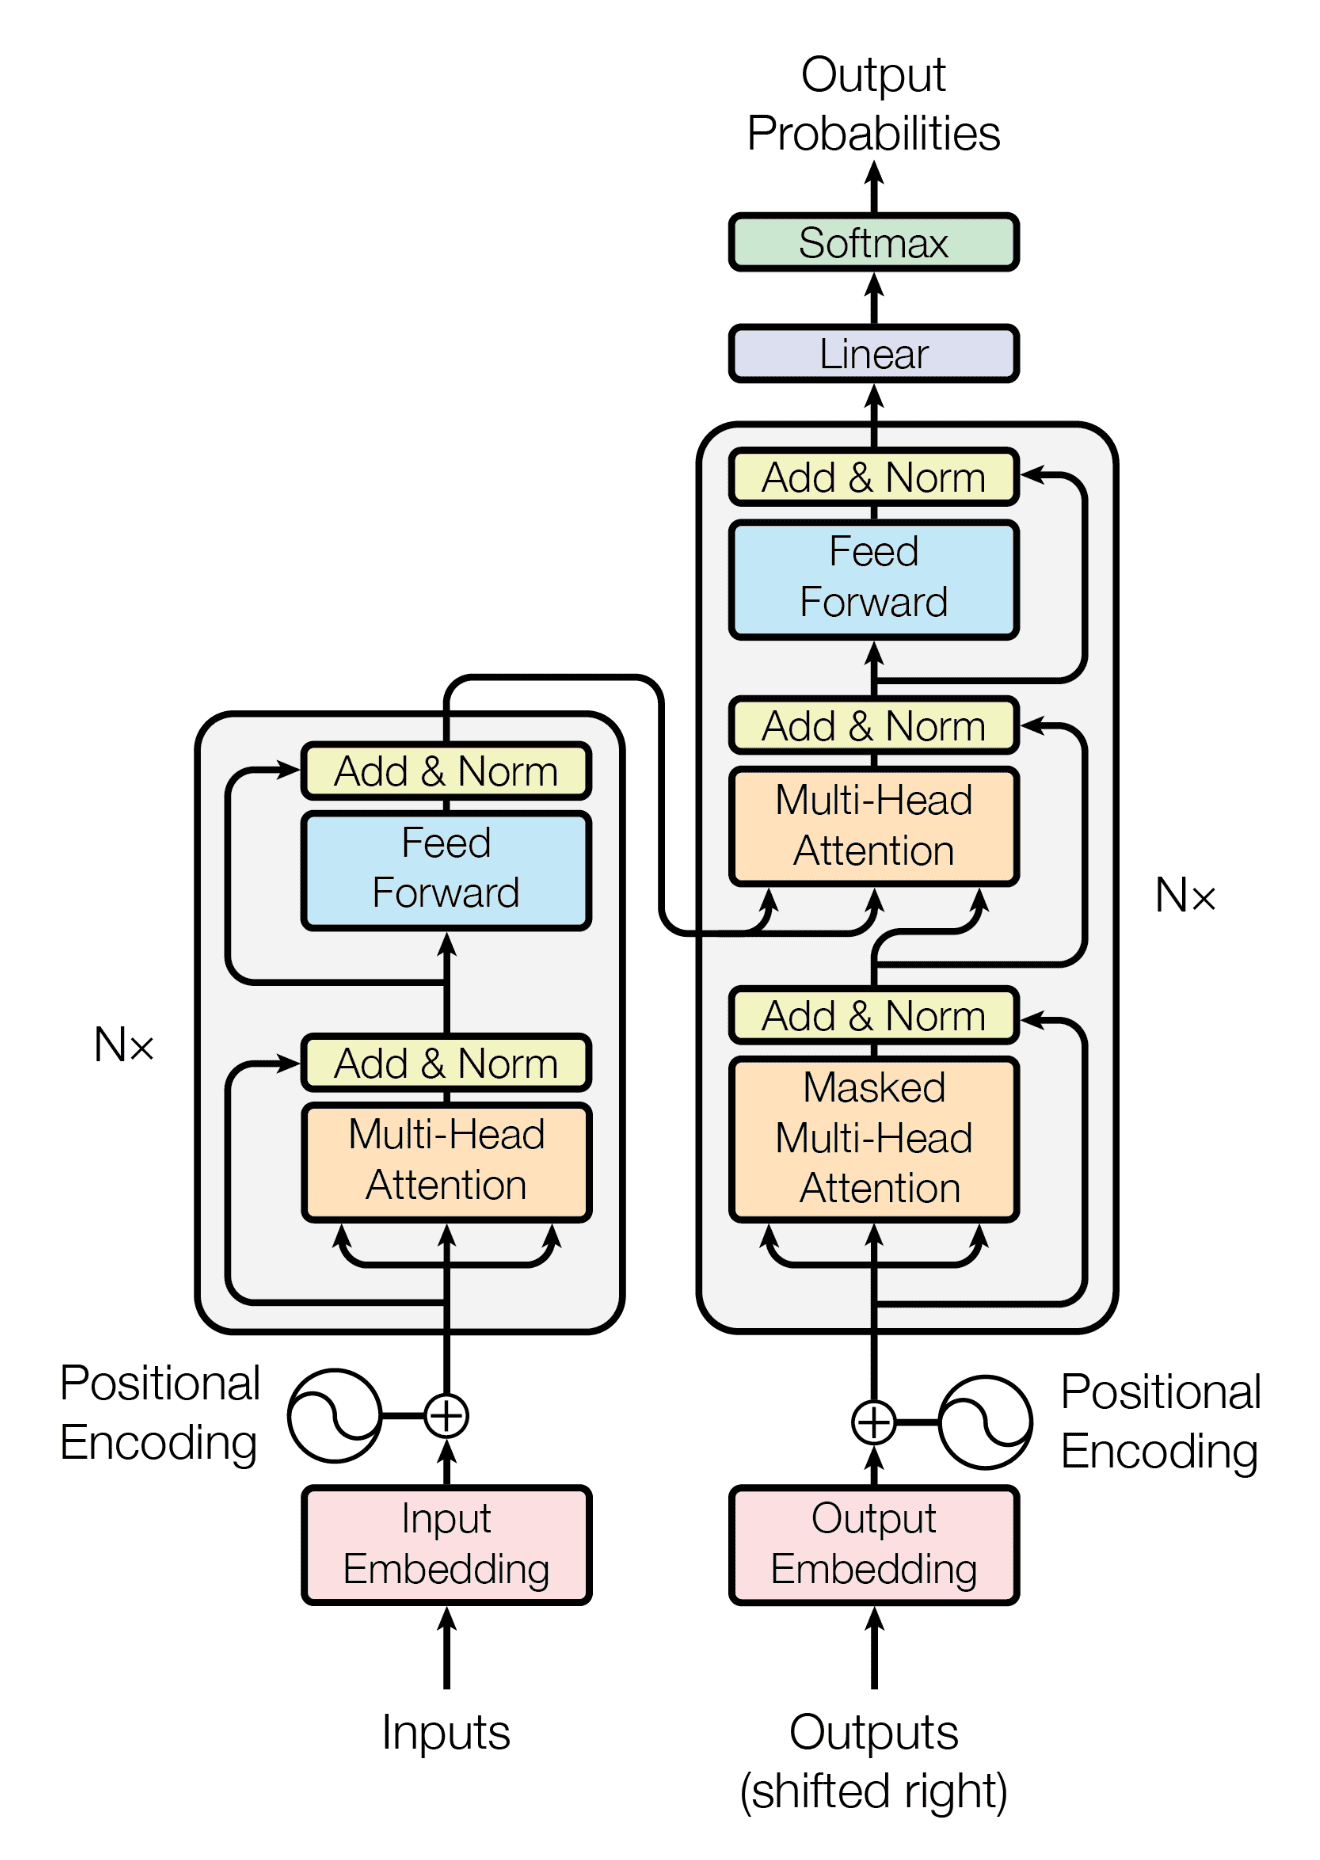



# **Load data**

In [2]:
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from string import punctuation
import pandas as pd

# Load data and set labels
data = pd.read_csv("/content/eng_-french.csv")

# Display dimensions of dataframe
print(data.shape)
print(data.info())

print("-----------------------------------------------------------------------")
# Display 10 random samples
print(data.sample(10))


(64932, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64932 entries, 0 to 64931
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   English words/sentences  64932 non-null  object
 1   French words/sentences   64931 non-null  object
dtypes: object(2)
memory usage: 1014.7+ KB
None
-----------------------------------------------------------------------
         English words/sentences                  French words/sentences
9679             You need to go.             Il faut que tu t'en ailles.
3213               Are you hurt?                 Vous êtes-vous blessé ?
10480           He puts on airs.                      Il prend des airs.
7304             Do as you want.                     Fais comme tu veux.
29673       I think I'm in love.         Je pense que je suis amoureuse.
13564          Can this be true?                Cela peut-il être vrai ?
49600    None of these are mine.      

In [3]:
# Clean the string
def clean_string(string):
    # Replace no-break space with space
    string = string.replace("\u202f"," ")
    # Converts all uppercase characters into lowercase characters
    string = string.lower()

    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")

    # Eliminate duplicate whitespaces using wildcards   
    string = re.sub("\s+"," ", string)
    # Remove spaces at the beginning and at the end of the string
    string = string.strip()
           
    return string

#-------------------------------------------------------------------------------
# object to string
data["English words/sentences"] = data["English words/sentences"].astype(str)
data["French words/sentences"]  = data["French words/sentences"].astype(str)

# Clean the sentences
data["English words/sentences"] = data["English words/sentences"].apply(lambda x: clean_string(x))
data["French words/sentences"]  = data["French words/sentences"].apply(lambda x: clean_string(x))

print("Done ...")


Done ...


In [4]:
# Get the raw data
raw_data_en = data["English words/sentences"].values
raw_data_fr = data["French words/sentences"].values

# Add start and end
raw_data_fr_in_out = ["[start] " + st + " [end]" for st in raw_data_fr]

for _ in range(5):
    print(random.choice(raw_data_fr_in_out))

print("\n---------------------------------------------------------------------")
# Each line contains an English sentence and its corresponding French sentence. 
# The English sentence is the source sequence and the French one is the target sequence.
my_data = []
for i in range(len(raw_data_en)):
    en = raw_data_en[i]
    fr = raw_data_fr_in_out[i]
    my_data.append((en, fr))

for _ in range(5):
    print(random.choice(my_data))


[start] je dois manger aussi [end]
[start] c était assez bon [end]
[start] quant à moi je courus dehors [end]
[start] avez vous aimé le film [end]
[start] beaucoup de temps fut gâché [end]

---------------------------------------------------------------------
('tom s working', '[start] tom est en train de travailler [end]')
('tom can t touch his toes', '[start] tom ne peut pas toucher ses orteils [end]')
('tom took off his belt', '[start] tom a retiré sa ceinture [end]')
('she is kissing him', '[start] elle l embrasse [end]')
('it s a waste of time', '[start] c est une perte de temps [end]')


In [5]:
# Shuffle data
random.shuffle(my_data)

# Train_set = 70%, Test_set = 15%, Val_set = 15%
num_val_samples = int(0.15 * len(my_data))
num_train_samples = len(my_data) - 2 * num_val_samples

train_pairs = my_data[:num_train_samples]
val_pairs   = my_data[num_train_samples : num_train_samples + num_val_samples]
test_pairs  = my_data[num_train_samples + num_val_samples :]

print("Total pairs in my dtat : ",len(my_data))
print("Training pairs         : ",len(train_pairs))
print("Validation pairs       : ",len(val_pairs))
print("Test pairs             : ",len(test_pairs))


Total pairs in my dtat :  64932
Training pairs         :  45454
Validation pairs       :  9739
Test pairs             :  9739


In [6]:
# Vectorizing the text data
vocab_size      = 15000
sequence_length = 20
batch_size      = 64

en_vectorization = TextVectorization(
    max_tokens = vocab_size, output_mode = "int", 
    output_sequence_length = sequence_length,)

fr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,)

train_en_texts = [pair[0] for pair in train_pairs]
train_fr_texts = [pair[1] for pair in train_pairs]

en_vectorization.adapt(train_en_texts)
fr_vectorization.adapt(train_fr_texts)
 
print("Done ...")


Done ...


In [7]:
def format_dataset(en, fr):
    en = en_vectorization(en)
    fr = fr_vectorization(fr)
    return ({"encoder_inputs": en, "decoder_inputs": fr[:, :-1],}, fr[:, 1:])

def make_dataset(pairs):
    en_texts, fr_texts = zip(*pairs)

    en_texts = list(en_texts)
    fr_texts = list(fr_texts)

    dataset = tf.data.Dataset.from_tensor_slices((en_texts, fr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_dataset = make_dataset(train_pairs)
val_dataset   = make_dataset(val_pairs)

for inputs, targets in train_dataset.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")


inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


# **Building the model**

# **Positional Embedding**

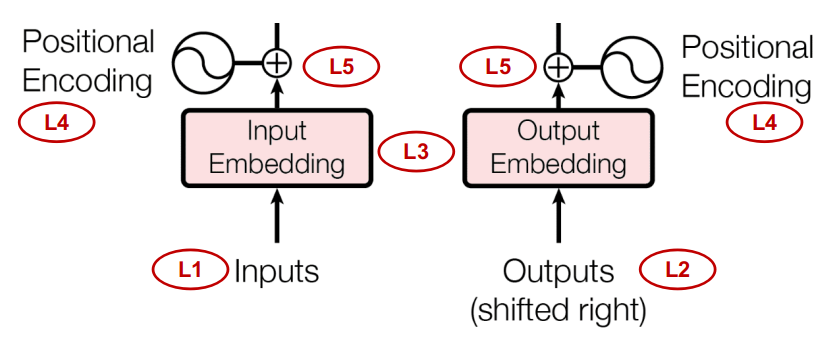

In [8]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
         #-----------------------------------------------------------------------
        self.sequence_length = sequence_length
        self.vocab_size      = vocab_size
        self.embed_dim       = embed_dim

        #-----------------------------------------------------------------------
        # L3
        self.input_embeddings = layers.Embedding(
                                     input_dim=vocab_size, output_dim=embed_dim)
        
        #-----------------------------------------------------------------------
        # L4
        self.positional_encoding = layers.Embedding(
                                input_dim=sequence_length, output_dim=embed_dim)
       
    #---------------------------------------------------------------------------
    def call(self, inputs):
        length    = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)

        # L3
        embedded_inputs    = self.input_embeddings(inputs)
        # L4
        embedded_positions = self.positional_encoding(positions)
        # L5
        return embedded_inputs + embedded_positions

    #---------------------------------------------------------------------------
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
        
#*******************************************************************************
print("Done ...")


Done ...


# **Transformer Encoder**

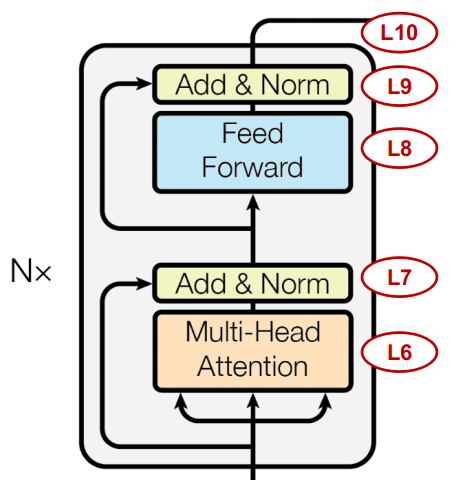

In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        #-----------------------------------------------------------------------
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        # L6
        self.attention = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        # L8
        self.feed_forward = keras.Sequential([
                                  layers.Dense(dense_dim, activation="relu"), 
                                   layers.Dense(embed_dim),])
        
        # L7
        self.normalization_1  = layers.LayerNormalization()
        # L9
        self.normalization_2  = layers.LayerNormalization()
        self.supports_masking = True

    #---------------------------------------------------------------------------
    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")

        #-----------------------------------------------------------------------
        # L6
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
        
        #-----------------------------------------------------------------------
        # L7
        addnorm_output_1 = self.normalization_1(inputs + attention_output)
        # L8
        feedforward_output = self.feed_forward(addnorm_output_1)
        # L9
        addnorm_output_2 = self.normalization_2(addnorm_output_1 + feedforward_output)
        # L10
        return addnorm_output_2

#*******************************************************************************
print("Done ...")


Done ...


# **Transformer Decoder**

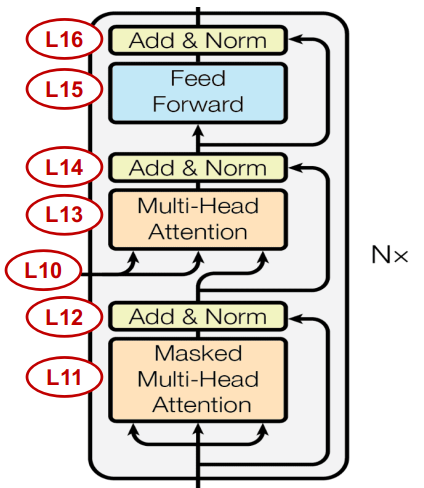

In [10]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        #-----------------------------------------------------------------------
        self.embed_dim  = embed_dim
        self.latent_dim = latent_dim
        self.num_heads  = num_heads

        #-----------------------------------------------------------------------
        # L11
        self.attention_1 = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        # L13
        self.attention_2 = layers.MultiHeadAttention(
                                         num_heads=num_heads, key_dim=embed_dim)
        #-----------------------------------------------------------------------
        # L15
        self.feed_forward = keras.Sequential([
          layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
        
        # L12
        self.normalization_1  = layers.LayerNormalization()
        # L14
        self.normalization_2  = layers.LayerNormalization()
        # L16
        self.normalization_3  = layers.LayerNormalization()
        self.supports_masking = True

    #---------------------------------------------------------------------------
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)

        #-----------------------------------------------------------------------
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        #-----------------------------------------------------------------------
        # L11
        attention_output_1 = self.attention_1(
             query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        # L12
        addnorm_output_1 = self.normalization_1(inputs + attention_output_1)

        #-----------------------------------------------------------------------
        # L13
        attention_output_2 = self.attention_2(
            query=addnorm_output_1, value=encoder_outputs, key=encoder_outputs,
            attention_mask=padding_mask,)
        # L14
        addnorm_output_2 = self.normalization_2(addnorm_output_1 + attention_output_2)

        #-----------------------------------------------------------------------
        # L15
        feedforward_output = self.feed_forward(addnorm_output_2)
        # L16
        addnorm_output_3 = self.normalization_3(addnorm_output_2 + feedforward_output)

        return addnorm_output_3

    #---------------------------------------------------------------------------
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
        
#*******************************************************************************
print("Done ...")


Done ...


# **Transformer**

Model: "my_transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embeddi

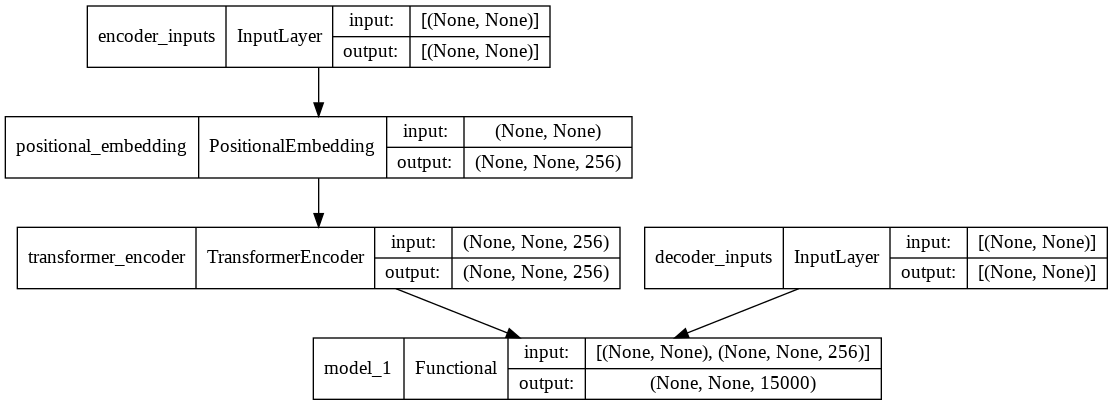

In [11]:
embed_dim  = 256
latent_dim = 2048
num_heads  = 8

#-------------------------------------------------------------------------------
# L1
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
# L3, L4, L5
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

#-------------------------------------------------------------------------------
# From L6 to L10
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
# Encoder
encoder         = keras.Model(encoder_inputs, encoder_outputs)

#-------------------------------------------------------------------------------
# L2
decoder_inputs     = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
# L10
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
# L3, L4, L5
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
# From L11 to L16
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)

#-------------------------------------------------------------------------------
# Output Probabilities
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

#-------------------------------------------------------------------------------
# Decoder
decoder         = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

#-------------------------------------------------------------------------------
# My Transformer
my_transformer = keras.Model(
                          [encoder_inputs, decoder_inputs], 
                          decoder_outputs, name="my_transformer")

# The model’s summary() method displays all the model’s layers
print(my_transformer.summary())

# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(my_transformer, show_shapes=True)


In [1]:
"""
TensorFlow Addons is a repository of contributions that conform to 
well-established API patterns, but implement new functionality not available 
in core TensorFlow. TensorFlow natively supports a large number of operators, 
layers, metrics, losses, and optimizers. However, in a fast moving field like ML, 
there are many interesting new developments that cannot be integrated into 
core TensorFlow (because their broad applicability is not yet clear, or it is 
mostly used by a smaller subset of the community).
"""
# https://www.tensorflow.org/addons/overview
!pip install -U tensorflow-addons


     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [12]:
# Optimizer
import tensorflow_addons as tfa
optimizer = tfa.optimizers.AdamW(
        learning_rate = 0.001, weight_decay=0.0001)

# Compiling the model
my_transformer.compile(loss="sparse_categorical_crossentropy", 
                       optimizer = optimizer, metrics = ["accuracy"])

# Training the model 
epochs = 30 # You have to train it longer to converge
history = my_transformer.fit(train_dataset, epochs=epochs, validation_data=val_dataset)



Epoch 1/30
711/711 [==============================] - 98s 128ms/step - loss: 1.0435 - accuracy: 0.5442 - val_loss: 0.7242 - val_accuracy: 0.6431
Epoch 2/30
711/711 [==============================] - 90s 126ms/step - loss: 0.6293 - accuracy: 0.6745 - val_loss: 0.5656 - val_accuracy: 0.7047
Epoch 3/30
711/711 [==============================] - 90s 126ms/step - loss: 0.4738 - accuracy: 0.7294 - val_loss: 0.5021 - val_accuracy: 0.7300
Epoch 4/30
711/711 [==============================] - 90s 126ms/step - loss: 0.3863 - accuracy: 0.7610 - val_loss: 0.4757 - val_accuracy: 0.7420
Epoch 5/30
711/711 [==============================] - 90s 127ms/step - loss: 0.3279 - accuracy: 0.7833 - val_loss: 0.4758 - val_accuracy: 0.7427
Epoch 6/30
711/711 [==============================] - 90s 127ms/step - loss: 0.2883 - accuracy: 0.8002 - val_loss: 0.4648 - val_accuracy: 0.7516
Epoch 7/30
711/711 [==============================] - 90s 126ms/step - loss: 0.2584 - accuracy: 0.8143 - val_loss: 0.4613 - val_ac

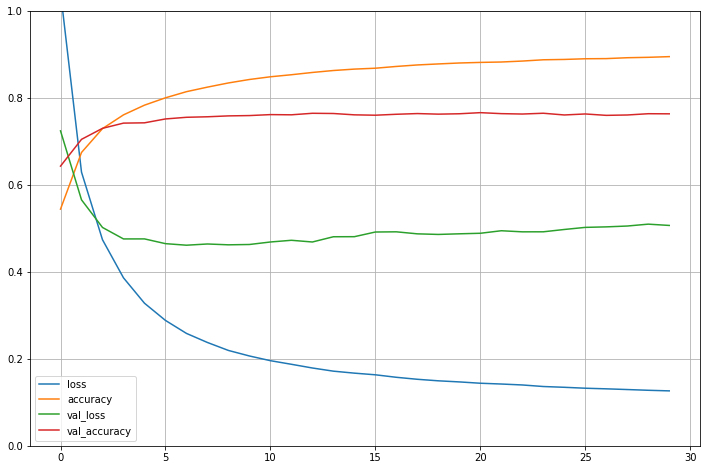

153/153 [==============================] - 8s 52ms/step - loss: 0.4982 - accuracy: 0.7643
Loss     :  0.4982260763645172
accuracy :  0.7643257975578308


In [13]:
# plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
test_dataset   = make_dataset(test_pairs)
model_evaluate = my_transformer.evaluate(test_dataset)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])


In [14]:
#-------------------------------------------------------------------------------
fr_vocab = fr_vectorization.get_vocabulary()
fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))
max_decoded_sentence_length = 20

#-------------------------------------------------------------------------------
def decode_sequence(input_sentence):
    tokenized_input_sentence = en_vectorization([input_sentence])

    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fr_vectorization([decoded_sentence])[:, :-1]
        predictions = my_transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

#-------------------------------------------------------------------------------
test_en_texts = [pair[0] for pair in test_pairs]
exp = 0
for i in range(30):
    input_sentence = random.choice(test_en_texts)
    translated = decode_sequence(input_sentence)
    print("Example : ",exp)
    print("En: ",test_en_texts[i])

    translated = translated.replace("[start]", "")
    translated = translated.replace("[UNK]", "")
    translated = translated.replace("end", "")
    print("Fr: ",translated)
    exp = exp + 1
    print("-------------------------------------------------------------------")


Example :  0
En:  let s sit down here
Fr:   n est ce pas agaçant               
-------------------------------------------------------------------
Example :  1
En:  why must we do it
Fr:   elle lui a acheté un chandail              
-------------------------------------------------------------------
Example :  2
En:  those are my books
Fr:   sont ils encore dans le lit              
-------------------------------------------------------------------
Example :  3
En:  i m just killing time
Fr:   contrôle est tout                 
-------------------------------------------------------------------
Example :  4
En:  what s your name
Fr:   ils méritent le respect                
-------------------------------------------------------------------
Example :  5
En:  tom never asked me
Fr:   je veux prre un instant               
-------------------------------------------------------------------
Example :  6
En:  i think you re right
Fr:   elle est fière de son fils              
-----------